# Effect of inertia on random walks

Inspired by [Gerard et al., 2014](https://pubmed.ncbi.nlm.nih.gov/25083865/). T cells depleted for Myo1g display motion patterns that are more "ballistic": higher speed and shallower angle of turn. Here, I use an "inertia" parameter to simulate how ballistic a given cell can be. We see that as inertia increases, both the 2D and 3D random walks show a probability cloud that is less dense near the center (fat tails), and which features shallower angles of turn between any two steps in the walk. 

Integrating the distance from origin times the absolute angles of each turn, we obtain a measure of how likely a T cell is to properly orient itself after a given amount of time in the random walk, which I will term the "bump score". In all cases, decreasing the inertia parameter will increase the average angle of turn and increase the density of points near the origin--the two conditions you need to increase the chance of receptor-antigen interaction when a T cell is in proximity with its target. 

We see that the benefit of decreasing the inertia parameter becomes more pronounced in higher dimensions, possibly explaining the finding in the paper that Myo1g is only involved in the regulation of 3D, but not 2D, Brownian motion. We can measure this benefit by looking at the mean +/- sd bump score after running the simulation; comparing the 2D to 3D cases of i=0, we see similar means but much tighter sd's, where the lower bound is decently far from zero. In other words, when comparing the 2D and 3D behavior when you decrease the inertia parameter, the 3D case is more likely to increase its bump scores **in a manner that steers clear of zero**, unlike in the 2D case (see: https://www.youtube.com/watch?v=iH2kATv49rc).

The paper shows that Myo1g regulates 3D motion by decreasing the "ballistic" nature of the cell. Assuming that our inertia parameter is a rough model for ballistic brownian motion, this gives us a more mechanistic understanding of how Myo1g decreasing ballisticity can contribute to improved antigen recognition purely by modifying cell-intrinsic motion.

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from matplotlib.cm import ScalarMappable
import scipy

class Point():
    def __init__(self, dims, inertia):
        self.dims = dims
        self.inertia = inertia
        self.pos = np.zeros(self.dims)

        self.pos_history = [self.pos]
        self.angle_history = [0]
        # self.prev_dir_vec = np.random.choice([-1,1], self.dims)
        self.prev_dir_vec = self.new_unit_vec()

    def update(self):
        # force_applied = np.random.choice([-1,1], self.dims)
        force_applied = self.new_unit_vec()
        prev_dir = self.prev_dir_vec

        direction = ((1-self.inertia) * force_applied) + (self.inertia * prev_dir)
        
        self.pos = self.pos + direction
        self.pos_history.append(self.pos)
        self.prev_dir_vec = direction

        # Calculate angle using cos(theta) = A.B/(|A||B|)
        interior = (np.dot(direction, prev_dir)) / (np.linalg.norm(direction) * np.linalg.norm(prev_dir))
        # Floating point corrections
        if interior < -1 and -1 - interior < 0.0001:
                interior = -1
        elif interior > 1 and interior - 1 < 0.0001:
                interior = 1
        
        angle = np.arccos(interior)
        self.angle_history.append(angle)

    def run(self, niter):
        for i in range(niter):
            self.update()

    def distances(self):
        return np.linalg.norm(self.pos_history, axis=1)
    
    def new_unit_vec(self):
        vec = np.random.randn(self.dims)
        return vec / np.linalg.norm(vec)

inertia:   0%|          | 0/5 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

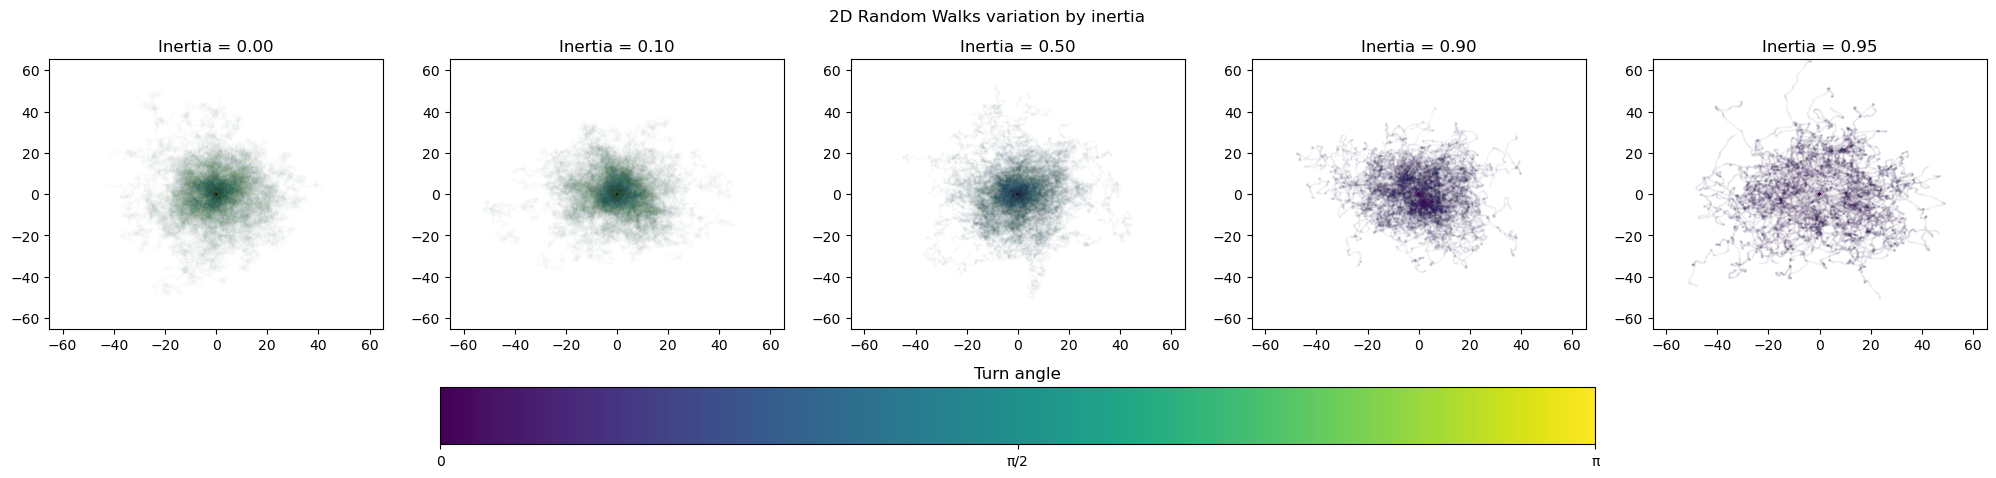

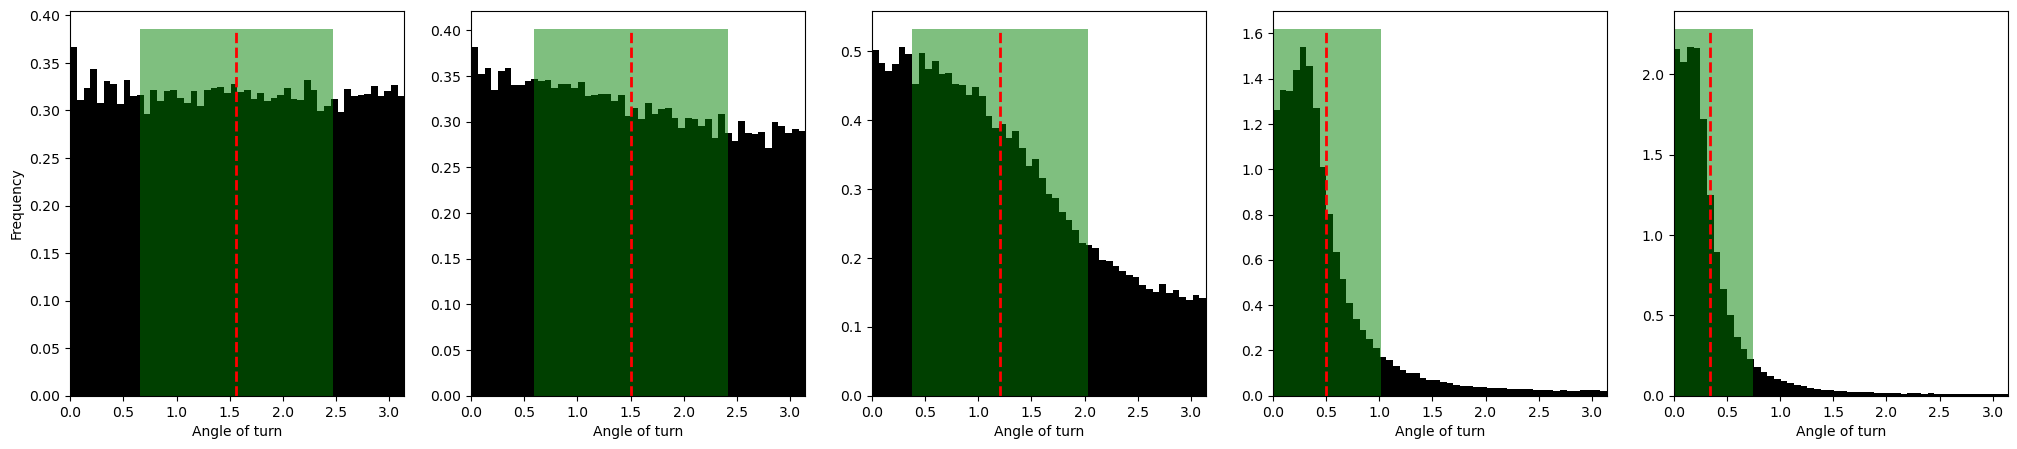

In [9]:
# 2D case

nreps = 150
nruns = 500 # 10000

cmap = plt.cm.viridis
norm = plt.Normalize(0, np.pi)
sm =  ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])

inertias = [0, 0.1, 0.5, 0.9, 0.95]


(fig, ax) = plt.subplots(1,len(inertias), figsize=(len(inertias)*5, 5))
res = {}
angles = {}
maximum = 0
for i, inertia in tqdm(enumerate(inertias), desc='inertia', total=len(inertias)):
    res[i] = {}
    angles[i] = []
    for rep in tqdm(range(nreps), desc='rep'):
        x = Point(dims=2, inertia=inertia)
        x.run(nruns)
        path = [pos for pos in x.pos_history]  # Only 2 dims here
        x_vals = [xy[0] for xy in path] 
        y_vals = [xy[1] for xy in path]
        maximum = max(maximum, np.max(np.abs(x_vals)), np.max(np.abs(y_vals)))

        # ax[i].plot(x_vals, y_vals, color='black', alpha=0.01)
        ax[i].scatter(x_vals, y_vals, c=x.angle_history, 
                      cmap=cmap, norm=norm, alpha=0.01, s = 0.7)
        angles[i].append(x.angle_history)

for i, inertia in enumerate(inertias):
    ax[i].set_xlim(-maximum, maximum)
    ax[i].set_ylim(-maximum, maximum)
    ax[i].set_title(f'Inertia = {inertia:.2f}')
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), 
                    ticks=[0, np.pi/2, np.pi], location='bottom')
cbar.ax.set_xticklabels(['0', 'π/2', 'π'])
cbar.ax.set_title("Turn angle")
fig.suptitle('2D Random Walks variation by inertia')

fig.show()
fig.savefig('randomwalk_2d.png', format='png', dpi=500)


(fig2, ax2) = plt.subplots(1,len(inertias), figsize=(len(inertias)*5, 5))
for i, inertia in enumerate(inertias):
    values = [y for x in angles[i] for y in x if not np.isnan(y)]
    avg = np.mean(values)
    sd = np.std(values)
    ax2[i].hist(values, color='black', density=True, bins=50)

    ymax = ax2[i].get_ylim()[1]
    ax2[i].fill_between(np.linspace(avg-sd, avg+sd, 100), 
                        ymax, facecolor='green', alpha=.5)
    ax2[i].vlines(avg, 0, ymax, colors='red', linestyles='--', lw=2)
    ax2[i].set_xlim(0, np.pi)
    if i==0:
        ax2[i].set_ylabel('Frequency')
    ax2[i].set_xlabel('Angle of turn')
fig2.show()
fig2.savefig('angle_distribution_2d.png', format='png', dpi=500)

inertia:   0%|          | 0/5 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

rep:   0%|          | 0/150 [00:00<?, ?it/s]

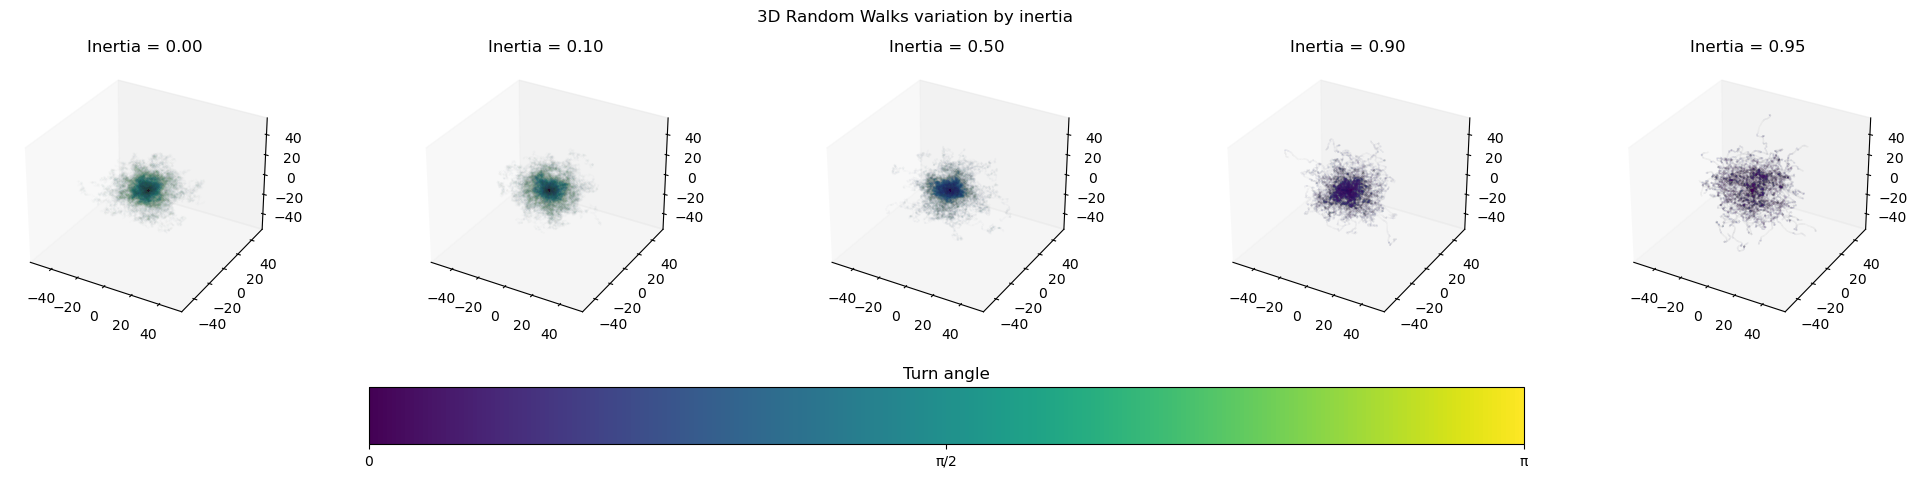

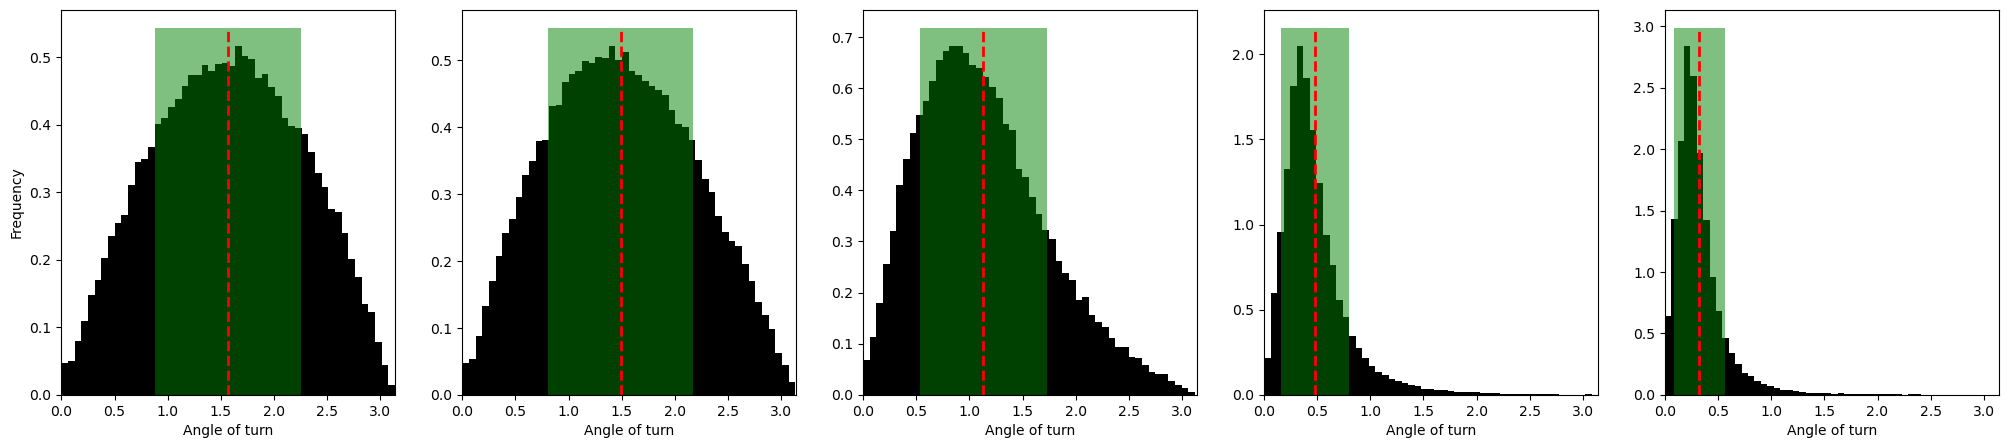

In [10]:
# 3D case

(fig, ax) = plt.subplots(1,len(inertias), 
                         figsize=(len(inertias)*5, 5), 
                         subplot_kw=dict(projection='3d'))
res = {}
angles = {}
maximum = 0
for i, inertia in tqdm(enumerate(inertias), desc='inertia', total=len(inertias)):
    angles[i] = []
    for rep in tqdm(range(nreps), desc='rep'):
        x = Point(dims=3, inertia=inertia)
        x.run(nruns)
        # path = [pos[:-1] for pos in x.pos_history]  # Just ignore the Z direction
        path = x.pos_history
        x_vals = [xy[0] for xy in path] 
        y_vals = [xy[1] for xy in path]
        z_vals = [xy[2] for xy in path]
        maximum = max(maximum, 
                      np.max(np.abs(x_vals)), 
                      np.max(np.abs(y_vals)),  
                      np.max(np.abs(z_vals)))

        # ax[i].plot(x_vals, y_vals, z_vals, color='black', alpha=0.01) 
        ax[i].scatter(x_vals, y_vals, z_vals, c=x.angle_history, 
                      cmap=cmap, norm=norm, alpha=0.01, s = 0.1)
        angles[i].append(x.angle_history)

for i, inertia in enumerate(inertias):
    ax[i].grid(False)
    ax[i].set_xlim(-maximum, maximum)
    ax[i].set_ylim(-maximum, maximum)
    ax[i].set_zlim(-maximum, maximum)
    ax[i].set_title(f'Inertia = {inertia:.2f}')
cbar = fig.colorbar(sm, ax=ax.ravel().tolist(), 
                    ticks=[0, np.pi/2, np.pi], location='bottom')
cbar.ax.set_xticklabels(['0', 'π/2', 'π'])
cbar.ax.set_title("Turn angle")
fig.suptitle('3D Random Walks variation by inertia')
fig.savefig('randomwalk_3d.png', format='png', dpi=500)
fig.show()



(fig2, ax2) = plt.subplots(1,len(inertias), figsize=(len(inertias)*5, 5))
for i, inertia in enumerate(inertias):
    values = [y for x in angles[i] for y in x if not np.isnan(y)]
    avg = np.mean(values)
    sd = np.std(values)
    ax2[i].hist(values, color='black', density=True, bins=50)

    ymax = ax2[i].get_ylim()[1]
    ax2[i].fill_between(np.linspace(avg-sd, avg+sd, 100), 
                        ymax, facecolor='green', alpha=.5)
    ax2[i].vlines(avg, 0, ymax, colors='red', linestyles='--', lw=2)
    ax2[i].set_xlim(0, np.pi)
    if i==0:
        ax2[i].set_ylabel('Frequency')
    ax2[i].set_xlabel('Angle of turn')
fig2.show()
fig2.savefig('angle_distribution_3d.png', format='png', dpi=500)


Dimension:   0%|          | 0/3 [00:00<?, ?it/s]

Inertia:   0%|          | 0/10 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Inertia:   0%|          | 0/10 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Inertia:   0%|          | 0/10 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

Repetition:   0%|          | 0/150 [00:00<?, ?it/s]

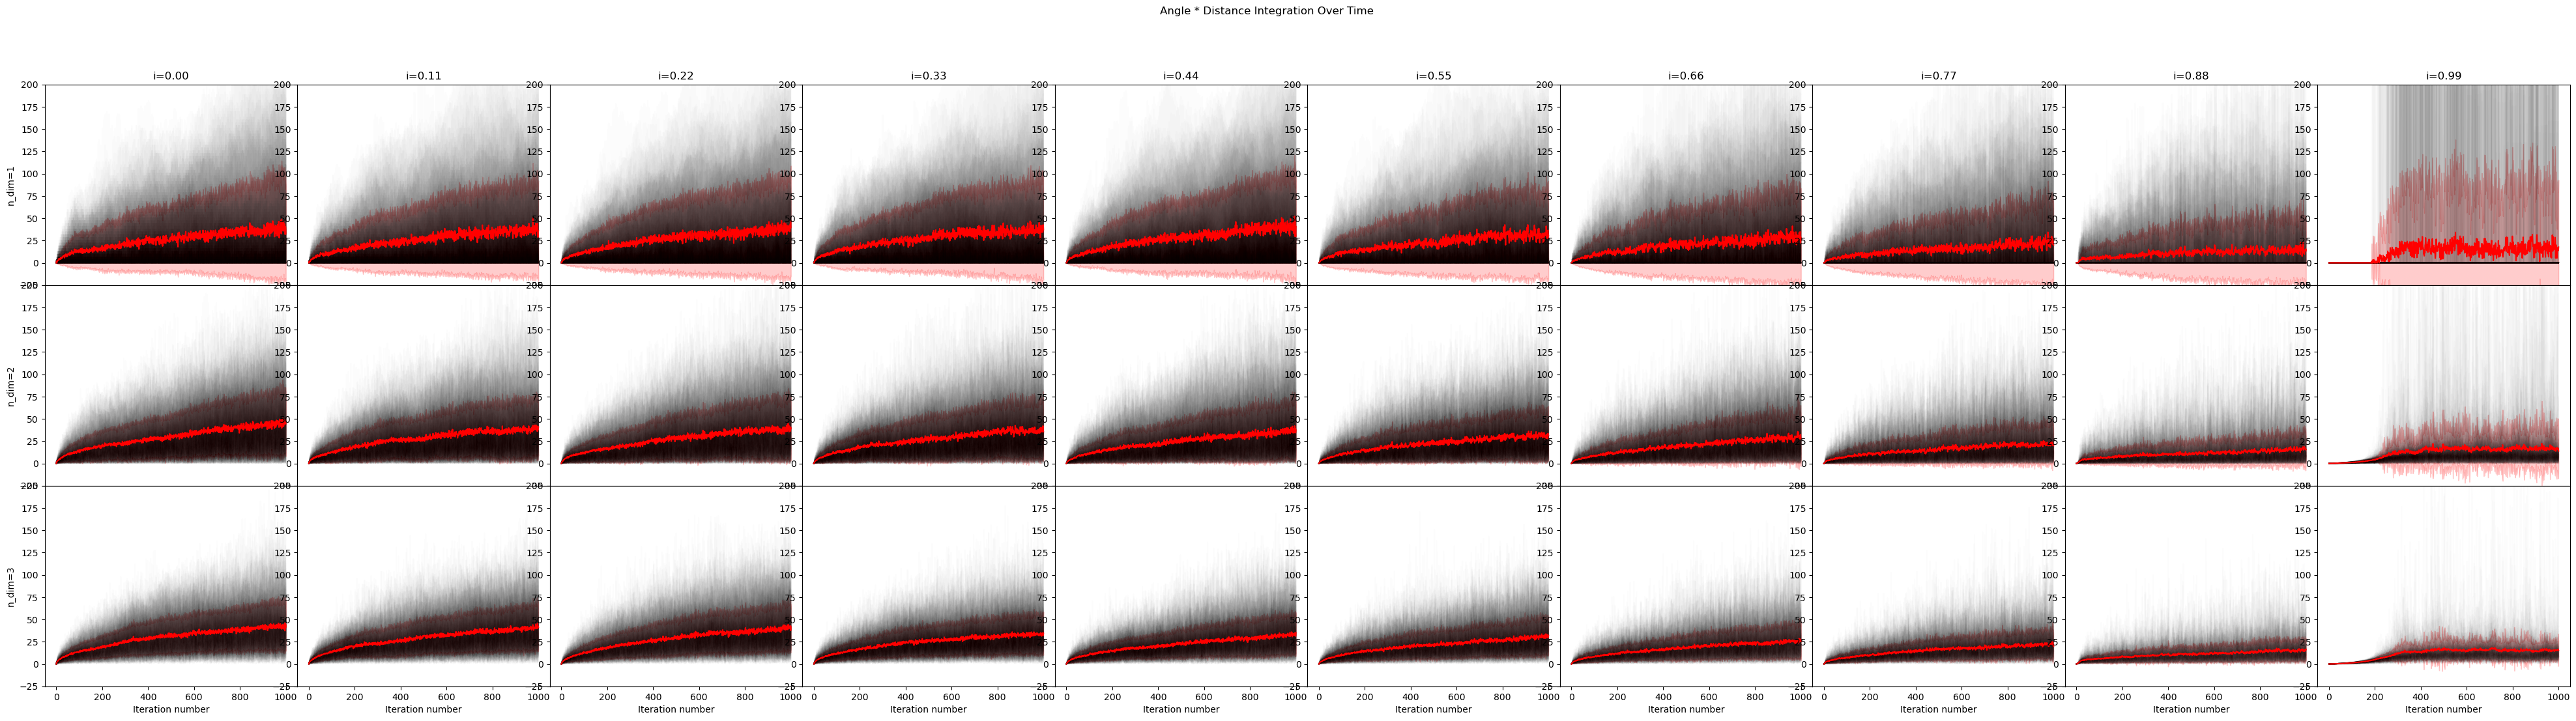

In [36]:
################################################################################

# Plot the integration of angle and distance

max_dim = 3
inertias = np.linspace(0, 0.99, 10)
n_panels = len(inertias)

nreps = 150
niter = 1000

dist_res = {}
(fig, ax) = plt.subplots(max_dim, n_panels, figsize=(5*n_panels, 12))


max_value = 0
row_max = 0
for ndim in tqdm(range(1,max_dim+1), desc='Dimension'):
    dist_res[ndim] = {}

    for i in tqdm(inertias, desc='Inertia'):
        dist_res[ndim][i] = {}
        for rep in tqdm(range(nreps), desc='Repetition'):
            x = Point(dims=ndim, inertia=i)
            x.run(niter)
            dist_res[ndim][i][rep] = np.multiply(x.angle_history, x.distances())
        
    
for ndim in range(1,max_dim+1):
    for i, inertia in enumerate(inertias):
        
        walks = dist_res[ndim][inertia]
        walk_mean = np.mean(list(walks.values()), axis=0)
        walk_sd = np.std(list(walks.values()), axis=0)
        for walknum, walk in walks.items():
            ax[ndim-1][i].plot(range(len(walk)), 
                               walk, color='black', alpha=0.01)
            # ax[ndim-1][i].scatter(range(len(walk)), walk, color='black', alpha=0.1, s=1)
            row_max = max(row_max, np.max(walk))
        max_value = max(max_value, row_max)
        ax[ndim-1][i].fill_between(range(len(walk_mean)), 
                                   walk_mean-walk_sd, walk_mean+walk_sd, 
                                   color='red', alpha=0.2)
        ax[ndim-1][i].plot(range(len(walk_mean)), 
                           walk_mean, color='red', alpha=1)
        
        # pval = scipy.stats.ttest_1samp([walk[-1] for walk in walks.values()], 
        #                                0).pvalue
        # if pval < 0.05:
        #     color= 'green'
        # else:
        #     color = 'red'
        # txt = f'p = {pval:.3e}'
        # ax[ndim-1][i].text(500, 175, txt, color=color)

        if ndim == 1:
            ax[ndim-1][i].set_title(f'i={inertia:.2f}')
        if ndim == max_dim:
            ax[ndim-1][i].set_xlabel('Iteration number')
        if i == 0:
            ax[ndim-1][i].set_ylabel(f'n_dim={ndim}')


for ndim in range(1,max_dim+1):
    for i, inertia in enumerate(inertias):
        # ax[ndim-1][i].set_ylim(0, max_value)
        ax[ndim-1][i].set_ylim(-25, 200)

fig.suptitle('Angle * Distance Integration Over Time')
fig.subplots_adjust(wspace=0, hspace=0)
fig.show()
fig.savefig('integration.png', format='png', dpi=500)
